<a href="https://colab.research.google.com/github/abragroup/AI-Course-finance-demo-alibaba/blob/master/finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#matrix math & data pre-processing
import numpy as np
# data formating
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/"

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo("BABA", start="2016-01-01").reset_index()
df_full.to_csv('alibaba.csv',index=False)
df_full.head()

Mounted at /content/drive
/content/drive/My Drive
[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,78.180000,78.309998,75.180000,76.690002,76.690002,23066300
1,2016-01-05,77.919998,78.680000,77.260002,78.629997,78.629997,14258900
2,2016-01-06,77.120003,78.485001,76.970001,77.330002,77.330002,11569300
3,2016-01-07,73.290001,75.500000,71.540001,72.720001,72.720001,27288100
4,2016-01-08,74.330002,74.660004,70.669998,70.800003,70.800003,20814600


In [2]:
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.45)


In [0]:
df_full = pd.read_csv('alibaba.csv')

In [0]:
df= df_full.copy()
name = 'Moving Average agent'

short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals
    
    

In [5]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 10,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 1000
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest
  
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 48: buy 10 units at price 733.499980, total balance 9266.500020
day 49: buy 10 units at price 722.300030, total balance 8544.199990
day 50: buy 10 units at price 735.000000, total balance 7809.199990
day 51: buy 10 units at price 742.500000, total balance 7066.699990
day 52: buy 10 units at price 762.500000, total balance 6304.199990
day 53: buy 10 units at price 781.100010, total balance 5523.099980
day 54: buy 10 units at price 781.800000, total balance 4741.299980
day 55: buy 10 units at price 765.599980, total balance 3975.700000
day 56: buy 10 units at price 758.600010, total balance 3217.099990
day 57: buy 10 units at price 764.800030, total balance 2452.299960
day 58: buy 10 units at price 780.800020, total balance 1671.499940
day 59: buy 10 units at price 788.600010, total balance 882.899930
day 60: buy 10 units at price 790.299990, total balance 92.599940
day 61: buy 1 units at price 78.730003, total balance 13.869937
day 62: total balances 13.869937, not enough money to b

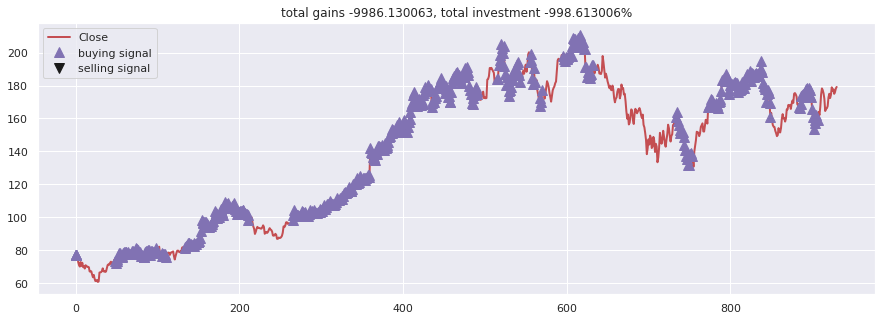

In [6]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('/'+name+'.png')
plt.show()


In [7]:
###  liniar regression test - Test environment

from sklearn.linear_model import LinearRegression

m = LinearRegression()
m.fit(df[["Open"]], df[["real_movement"]])

print  ("intercept: " + str(model.intercept_))
print("Coef: " + str(model.coef_))

min_x = min(df["Quadratmeter"])
max_x = max(df["Quadratmeter"])

predicted  = model.predict([[min_x], [max_x]])

plt.scatter(df["X-Achse"], df["Y-Achse"])
plt.plot([min_x, max_x], predicted, color = "red")
plt.show()

KeyError: ignored